In [1]:
import os
import requests
import zipfile
import geopandas as gpd
from shapely.geometry import Polygon

from datetime import datetime, timedelta, timezone

start = datetime(2024, 1, 1, tzinfo=timezone.utc)
end = datetime(2024, 5, 30, tzinfo=timezone.utc)
frame_duration = timedelta(days=1)
num_frames = int(1 + (end - start) / frame_duration)

# automatically download/extract watershed boundary shapefiles
for wbd in [10]:
    if not os.path.isfile(f"WBD_{wbd}_HU2_Shape/Shape/WBDHU2.shp"):
        print(f"Downloading/extracting WBD {wbd}")
        r = requests.get(
            f"https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/Shape/WBD_{wbd}_HU2_Shape.zip"
        )
        with open(f"WBD_{wbd}_HU2_Shape.zip", "wb") as zip_file:
            zip_file.write(r.content)
        with zipfile.ZipFile(f"WBD_{wbd}_HU2_Shape.zip", 'r') as zip_file:
            zip_file.extractall(f"WBD_{wbd}_HU2_Shape")

mo_basin = gpd.read_file("WBD_10_HU2_Shape/Shape/WBDHU2.shp")
mo_basin = gpd.GeoSeries(Polygon(mo_basin.iloc[0].geometry.exterior), crs="EPSG:4326")

# access us states shapefile
us_map = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")
conus = us_map[~us_map.STUSPS.isin(["AK", "HI", "PR"])].to_crs("EPSG:4326")
# note: requires gdal (has platform-specific binaries)
# recommend conda distribution: `conda install -c conda-forge gdal`
from osgeo import gdal

from datetime import datetime
import gzip
import os
import requests
import shutil
import tarfile
import tempfile

import pandas as pd
import rioxarray as rxr
import xarray as xr

dates = pd.date_range(start, end)
snodas_dir = "SNODAS"
if not os.path.exists(snodas_dir):
    os.makedirs(snodas_dir)

for date in dates:
    # Make sure the date is timezone-aware
    date = datetime(date.year, date.month, date.day, tzinfo=timezone.utc)

    file_label = f"us_ssmv11034tS__T0001TTNATS{date.strftime('%Y')}{date.strftime('%m')}{date.strftime('%d')}05HP001.nc"
    
    # check if file already exists
    if os.path.isfile(os.path.join(snodas_dir, file_label)):
        print("Skipping " + file_label)
        continue
    print("Processing " + file_label)
    dir_label = f"SNODAS_{date.strftime('%Y%m%d')}"
    # request the .tar file
    r = requests.get(
        "https://noaadata.apps.nsidc.org/NOAA/G02158/masked/" + 
        f"{date.strftime('%Y')}/{date.strftime('%m')}_{date.strftime('%b')}/" +
        dir_label + ".tar"
    )
    # do work in temp directory
    with tempfile.TemporaryDirectory() as tmp_dir:
        # save the .tar file
        with open(os.path.join(tmp_dir, dir_label + ".tar"), "wb") as tar_file:
            tar_file.write(r.content)
        # open and extract the .tar file
        with tarfile.open(os.path.join(tmp_dir, dir_label + ".tar"), "r") as tar_file:
            tar_file.extractall(tmp_dir)
        # iterate through all files
        for filename in os.listdir(tmp_dir):
            if os.path.isfile(os.path.join(tmp_dir, filename)) and all(s in filename for s in ["v11034", ".dat.gz"]):
                # unzip the swe .gz file
                with gzip.open(os.path.join(tmp_dir, filename), "rb") as gz_in:
                    with open(os.path.join(tmp_dir, filename.replace(".gz", "")), "wb") as gz_out:
                        shutil.copyfileobj(gz_in, gz_out)
                # write the .hdr file
                with open(os.path.join(tmp_dir, filename.replace(".dat.gz", ".hdr")), "w") as hdr_file:
                    hdr_file.write(
                        "ENVI\n"
                        "samples = 6935\n" +
                        "lines = 3351\n" +
                        "bands = 1\n" +
                        "header offset = 0\n" + 
                        "file type = ENVI Standard\n" + 
                        "data type = 2\n" +
                        "interleave = bsq\n" +
                        "byte order = 1"
                    )
                # run the gdal translator
                if date < datetime(2013, 10, 1, tzinfo=timezone.utc):
                    command = " ".join([
                        "gdal_translate",
                        "-of NetCDF",
                        "-a_srs EPSG:4326",
                        "-a_nodata -9999",
                        "-a_ullr -124.73375000000000 52.87458333333333 -66.94208333333333 24.94958333333333",
                        os.path.join(tmp_dir, filename.replace(".dat.gz", ".dat")),
                        os.path.join(snodas_dir, filename.replace(".dat.gz", ".nc"))
                    ])
                else:
                    command = " ".join([
                        "gdal_translate",
                        "-of NetCDF",
                        "-a_srs EPSG:4326",
                        "-a_nodata -9999",
                        "-a_ullr -124.73333333333333 52.87500000000000 -66.94166666666667 24.95000000000000",
                        os.path.join(tmp_dir, filename.replace(".dat.gz", ".dat")),
                        os.path.join(snodas_dir, filename.replace(".dat.gz", ".nc"))
                    ])
                if os.system(command) > 0: 
                    print(f"Error processing command `{command}`")

print("Merging datasets...")
ds = xr.combine_by_coords(
    [
        rxr.open_rasterio(
            os.path.join(
                snodas_dir, 
                f"us_ssmv11034tS__T0001TTNATS{date.strftime('%Y')}{date.strftime('%m')}{date.strftime('%d')}05HP001.nc"
            )
        ).rio.clip(mo_basin.envelope).assign_coords(time=date).expand_dims(dim="time")
        for date in dates
    ], 
    combine_attrs="drop_conflicts"
).sel(band=1).rename_vars({"Band1": "SWE"})
ds.SWE.attrs["long_name"] = "Snow Water Equivalent"
ds.SWE.attrs["units"] = "mm"

print("Writing snodas-merged.nc")
ds.to_netcdf(os.path.join(snodas_dir, "snodas-merged.nc"))


Downloading/extracting WBD 10
Processing us_ssmv11034tS__T0001TTNATS2024010105HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024010205HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024010305HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024010405HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024010505HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024010605HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024010705HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024010805HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024010905HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024011005HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024011105HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024011205HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024011305HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024011405HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024011505HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024011605HP001.nc
Processing us_ssmv11034tS__T0001TTNATS2024011705HP001.nc
P

In [2]:
from rasterio.enums import Resampling
swe = ds.SWE.rio.reproject(ds.SWE.rio.crs, shape=(ds.SWE.shape[1]//100, ds.SWE.shape[2]//100), resampling=Resampling.average)

In [3]:
display(swe)

<xarray.DataArray 'SWE' (time: 151, y: 15, x: 28)> Size: 127kB
array([[[    4,     1,     0, ..., -9999, -9999, -9999],
        [   47,    23,     0, ...,     1,     0,     0],
        [  105,    52,     0, ...,     0,     0,     0],
        ...,
        [    0,    13,    25, ...,     0,     0,     0],
        [    0,    11,    23, ...,     0,     0,     0],
        [    0,     1,     1, ...,     0,     0,     0]],

       [[    4,     1,     0, ..., -9999, -9999, -9999],
        [   47,    23,     0, ...,     1,     0,     0],
        [  104,    52,     0, ...,     0,     0,     0],
        ...,
        [    0,    12,    25, ...,     0,     0,     0],
        [    0,    11,    22, ...,     0,     0,     0],
        [    0,     1,     1, ...,     0,     0,     0]],

       [[    4,     1,     0, ..., -9999, -9999, -9999],
        [   46,    23,     0, ...,     1,     0,     0],
        [  104,    52,     0, ...,     0,     0,     0],
        ...,
...
        ...,
        [    0,     4,     9, ...,     0,     0,     0],
        [    0,     8,    16, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[   21,     5,     0, ..., -9999, -9999, -9999],
        [  109,    54,     0, ...,     0,     0,     0],
        [  295,   147,     0, ...,     0,     0,     0],
        ...,
        [    0,     4,     7, ...,     0,     0,     0],
        [    0,     8,    16, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[   19,     5,     0, ..., -9999, -9999, -9999],
        [  100,    50,     0, ...,     0,     0,     0],
        [  280,   139,     0, ...,     0,     0,     0],
        ...,
        [    0,     3,     5, ...,     0,     0,     0],
        [    0,     6,    12, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]]], dtype=int16)
Coordinates:
  * x        (x) float64 224B -113.5 -112.7 -111.8 ... -92.24 -91.39 -90.54
  * y        (y) float64 120B 49.32 48.47 47.62 46.77 ... 39.99 39.14 38.3 37.45
    band     int32 4B 1
  * time     (time) datetime64[ns] 1kB 2024-01-01 2024-01-02 ... 2024-05-30
    crs      int32 4B 0
Attributes: (12/13)
    lat#long_name:      latitude
    lat#standard_name:  latitude
    lat#units:          degrees_north
    lon#long_name:      longitude
    lon#standard_name:  longitude
    lon#units:          degrees_east
    ...                 ...
    GDAL:               GDAL 3.6.4, released 2023/04/17
    long_name:          Snow Water Equivalent
    scale_factor:       1.0
    add_offset:         0.0
    units:              mm
    _FillValue:         -9999

In [4]:
# from tatc import utils
# from tatc.schemas import Instrument, Satellite, TwoLineElements

# epoch = datetime(2024, 9, 28, tzinfo=timezone.utc)

# amsr2 = Instrument(
#     name="AMSR2",
#     field_of_regard=utils.swath_width_to_field_of_regard(700e3, 1450e3), # 1450 km swath at 700 km altitude
# )
# gcom_2 = Satellite(
#     name="GCOM-W",
#     orbit=TwoLineElements(
#         tle = [
#           "1 38337U 12025A   24272.58165200  .00002202  00000+0  49847-3 0  9998",
#           "2 38337  98.2087 211.0739 0002482  86.8666  86.0375 14.57127053657786"
#         ]
#     ),
#     instruments=[amsr2],
# )
# sar = Instrument(
#     name="Ku SAR",
#     field_of_regard=utils.swath_width_to_field_of_regard(600e3, 500e3)# +/- 50 degrees off-nadir
# )
# capella = Satellite(
#     name="Capella 14",
#     orbit=TwoLineElements(
#         tle = [
#           "1 59444U 24066C   24271.33678418  .00006721  00000+0  70834-3 0  9990",
#           "2 59444  45.6096 275.2802 0000442 302.6951  57.3884 14.90019720 18085"
#         ]
#     ),
#     instruments=[sar],
# )


# satellite_instrument_pairs = [(gcom_2, amsr2), (capella, sar)]
# import pandas as pd
# from tatc.analysis import compute_ground_track
# from datetime import timedelta

# def get_ground_tracks(epoch, frame_duration, frame, satellite_instrument_pairs, clip_geo):
#     return pd.concat(
#         [
#             compute_ground_track(
#                 satellite_instrument_pair[0], # satellite
#                 satellite_instrument_pair[1], # instrument
#                 pd.date_range(
#                     epoch + frame*frame_duration, 
#                     epoch + (frame + 1)*frame_duration,
#                     freq=timedelta(seconds=10)
#                 ),
#                 mask=clip_geo,
#                 crs="EPSG:3857"
#             ) 
#             for satellite_instrument_pair in satellite_instrument_pairs
#         ]
#     )
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import matplotlib.animation as animation
# import matplotlib.lines as lines
# import matplotlib.patches as patches
# import matplotlib.colors as colors
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import numpy as np
# from IPython.display import HTML

# mpl.rcParams["animation.embed_limit"] = 100 # MB

# vmin = 0
# vmax = swe.max()

# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) #ccrs.AlbersEqualArea(-102.5, 43.5))

# swe.isel(time=0).plot(
#     ax=ax, 
#     add_colorbar=True, 
#     vmin=vmin, 
#     vmax=vmax, 
#     cmap="bone_r", 
#     cbar_kwargs={"label": "Snow Water Equivalent (mm)"},
#     transform=ccrs.PlateCarree()
# )

# def animate(frame):
#     ax.clear()
#     ax.set_facecolor("gray")
#     ax.add_feature(cfeature.STATES)
#     mo_basin.boundary.plot(ax=ax, color="red", transform=ccrs.PlateCarree())
#     conus.boundary.clip(mo_basin.envelope).plot(ax=ax, color="black", lw=0.5)
#     swe_tmp = swe.sel(time=start.replace(tzinfo=None) + frame * frame_duration)
#     swe_tmp.where(swe_tmp>0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, cmap="bone_r", transform=ccrs.PlateCarree())
#     # plot the ground tracks
#     time = epoch + frame * frame_duration
#     #nt_tracks = ground_tracks[(ground_tracks.time==time) & (ground_tracks.satellite=="GCOM-W")]
#    # if not nt_tracks.empty:
#         #nt_tracks.plot(ax=ax, color=colors.to_rgba("green", 0.1), ec="green", lw=1, transform=ccrs.PlateCarree()._as_mpl_transform(ax))
#     #t_tracks = ground_tracks[(ground_tracks.time==time) & (ground_tracks.satellite=="Capella 14")]
#     #if not t_tracks.empty:
#        # t_tracks.plot(ax=ax, color=colors.to_rgba("yellow", 0.1), ec="yellow", lw=1, transform=ccrs.PlateCarree()._as_mpl_transform(ax))
#     ax.set_title((start + frame * frame_duration).strftime("%Y-%m-%d"))
#     ax.legend(handles=[
#         lines.Line2D([0],[0],label="Missouri River Basin", linewidth=1, color="red"),
#         patches.Patch(label="Non-taskable Ground Track", color=colors.to_rgba("green", 0.1), ec="green", lw=1),
#         patches.Patch(label="Taskable Ground Track", color=colors.to_rgba("yellow", 0.1), ec="yellow", lw=1)
#     ])

# ani = animation.FuncAnimation(fig, animate, frames=num_frames, interval=200, blit=False)
# display(HTML(ani.to_jshtml()))
# # ani.save("sos.gif", dpi=300, writer=animation.PillowWriter(fps=5))
# plt.close()

In [5]:
# Before reprojecting
num_rows, num_cols = ds.SWE.shape[1], ds.SWE.shape[2]
num_grid_cells = num_rows * num_cols
print(f"Original grid size: {num_rows} rows x {num_cols} columns")
print(f"Total grid cells: {num_grid_cells}")

# After reprojecting
swe_reprojected = ds.SWE.rio.reproject(ds.SWE.rio.crs, shape=(ds.SWE.shape[1]//100, ds.SWE.shape[2]//100), resampling=Resampling.average)

# Reprojected dimensions
num_rows_reprojected, num_cols_reprojected = swe_reprojected.shape[1], swe_reprojected.shape[2]
num_grid_cells_reprojected = num_rows_reprojected * num_cols_reprojected
print(f"Reprojected grid size: {num_rows_reprojected} rows x {num_cols_reprojected} columns")
print(f"Total grid cells after reprojecting: {num_grid_cells_reprojected}")


Original grid size: 1526 rows x 2859 columns
Total grid cells: 4362834
Reprojected grid size: 15 rows x 28 columns
Total grid cells after reprojecting: 420


In [6]:
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime

# Ensure dimensions of size 1 are squeezed out
if 'band' in swe.dims and swe.sizes['band'] == 1:
    swe = swe.squeeze('band')

# Mask NaN values in SWE
swe_masked = swe.where(~np.isnan(swe))

# Calculate the absolute SWE difference between consecutive time steps
swe_diff_abs = abs(swe_masked.diff(dim='time')).where(~np.isnan(swe_masked.diff(dim='time')))

# Add a zero difference for the first time step to match the length
swe_diff_abs = xr.concat([xr.zeros_like(swe.isel(time=0)), swe_diff_abs], dim='time')

# Set the threshold for SWE change
threshold = 15

# Create a list to store the results
results = []

# Iterate through the dataset and check for each grid cell
for t in range(len(swe_diff_abs.time)):
    # Extract the SWE difference for the current time step
    swe_diff_time = swe_diff_abs.isel(time=t)
    
    # Check if any grid cell exceeds the threshold
    grid_cells_exceeding_threshold = swe_diff_time.where(swe_diff_time > threshold, drop=True)
    
    if not grid_cells_exceeding_threshold.isnull().all():
        # Get the date of the current time step
        date = swe['time'].isel(time=t).values.astype('datetime64[D]')
        
        # Convert to a Python datetime object to access 'year'
        date_obj = pd.to_datetime(date)
        
        # Calculate the number of days since the start of the year (January 1st)
        day_from_start = (date_obj - datetime(date_obj.year, 1, 1)).days + 1
        
        # Append the results
        results.append([date, day_from_start])

# Convert results to a DataFrame
dates_df = pd.DataFrame(results, columns=["Date", "Days_from_start"])

# Calculate the interarrival days by taking the difference between consecutive dates
dates_df['Interarrival_days'] = dates_df['Date'].diff().fillna(pd.Timedelta(0)).dt.days

# Remove the first row
dates_df = dates_df.iloc[1:].reset_index(drop=True)

# Save the DataFrame to a CSV file
output_csv = 'dates_with_interarrival.csv'
dates_df.to_csv(output_csv, index=False)

# Print confirmation and show a preview of the DataFrame
print(f"Dates where SWE change exceeds the threshold saved to '{output_csv}'.")
print(dates_df.head())


Dates where SWE change exceeds the threshold saved to 'dates_with_interarrival.csv'.
        Date  Days_from_start  Interarrival_days
0 2024-01-10               10                  1
1 2024-01-11               11                  1
2 2024-01-13               13                  2
3 2024-01-15               15                  2
4 2024-01-17               17                  2


In [7]:
import pandas as pd

# Load interarrival times from CSV
ps = pd.read_csv('dates_with_interarrival.csv')
print(ps)

          Date  Days_from_start  Interarrival_days
0   2024-01-10               10                  1
1   2024-01-11               11                  1
2   2024-01-13               13                  2
3   2024-01-15               15                  2
4   2024-01-17               17                  2
..         ...              ...                ...
74  2024-05-21              142                  2
75  2024-05-24              145                  3
76  2024-05-25              146                  1
77  2024-05-26              147                  1
78  2024-05-30              151                  4

[79 rows x 3 columns]


95% Confidence Interval for the Mean: (1.5316455696202531, 2.0632911392405062)


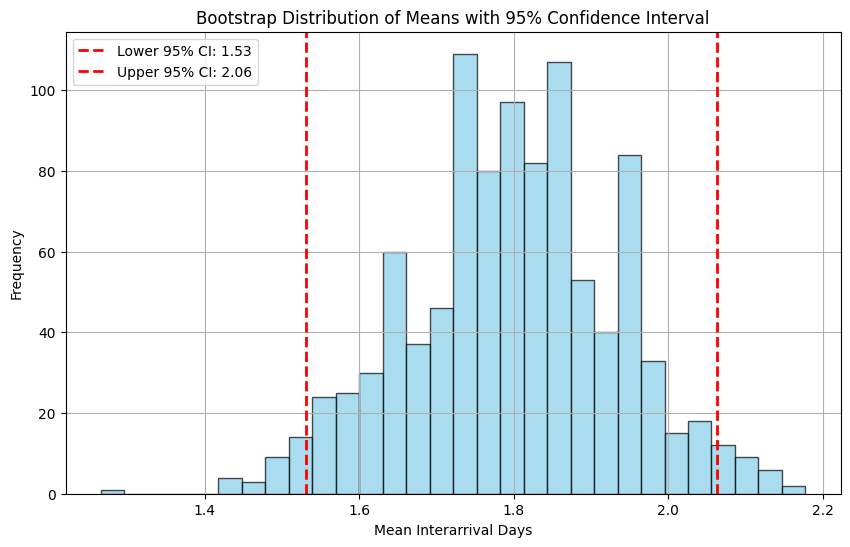

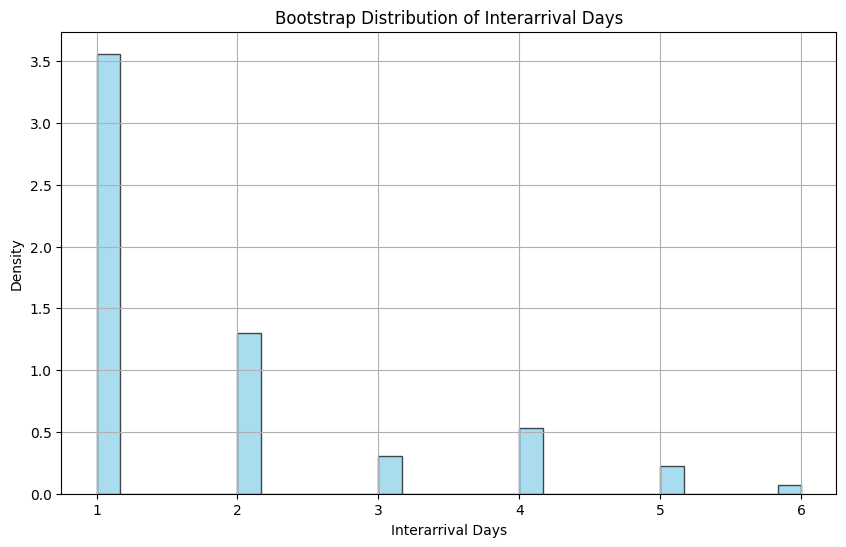

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'dates_df' is the DataFrame with 'Interarrival_days' column

# Set the number of bootstrap iterations
n_iterations = 1000

# Create a list to store the bootstrap samples
bootstrap_samples = []
bootstrap_means = []
# Perform bootstrap sampling
for i in range(n_iterations):
    # Sample with replacement from the 'Interarrival_days' column
    sample = dates_df['Interarrival_days'].sample(frac=1, replace=True).values
    bootstrap_samples.append(sample)  
    sample_mean = np.mean(sample) 
    bootstrap_means.append(sample_mean)

bootstrap_means = np.array(bootstrap_means)
#display(bootstrap_means)

# Calculate the 95% confidence interval (using the 2.5th and 97.5th percentiles)
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

# Print the confidence interval
print(f"95% Confidence Interval for the Mean: ({lower_bound}, {upper_bound})")

# Plot the histogram of the bootstrap means
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_means, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=lower_bound, color='red', linestyle='dashed', linewidth=2, label=f"Lower 95% CI: {lower_bound:.2f}")
plt.axvline(x=upper_bound, color='red', linestyle='dashed', linewidth=2, label=f"Upper 95% CI: {upper_bound:.2f}")
plt.title("Bootstrap Distribution of Means with 95% Confidence Interval")
plt.xlabel('Mean Interarrival Days')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
# Flatten the list of samples for histogram plotting
flattened_samples = [sample for sublist in bootstrap_samples for sample in sublist]

# Plot the histogram of all bootstrap samples
plt.figure(figsize=(10, 6))
plt.hist(flattened_samples, bins=30, color='skyblue', edgecolor='black', alpha=0.7, density=True)
plt.title("Bootstrap Distribution of Interarrival Days")
plt.xlabel('Interarrival Days')
plt.ylabel('Density')
plt.grid(True)
plt.show()